In [1]:
from osgeo import gdal, osr
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np
import csv
from pyproj import Proj, transform
import math
from scipy.io import savemat

DEM 데이터 적재, 행렬형태로 변환, 시각화, csv 포맷으로 저장

In [2]:
# 파일을 불러와 넘파이 배열로 저장
gdal.UseExceptions()

# Load DEM data
dem_file = 'C:/Users/leeyj/lab_ws/data/VTD/지형 데이터/flat_field.tif'
# dem_file = "D:/OneDrive - 인하대학교/School/과제/[국방 수직이착륙기 특화연구센터(VTD-13)]/Test_DEM.tif"
dataset = gdal.Open(dem_file)
band = dataset.GetRasterBand(1)
elevation = band.ReadAsArray()

# Get geotransform info
geotransform = dataset.GetGeoTransform()

# Initialize an empty list to store the data
matrix = []

# Calculate longitude, latitude, and elevation for each pixel
for y in range(elevation.shape[0]):
    row = []
    for x in range(elevation.shape[1]):
        longitude = geotransform[0] + x*geotransform[1] + y*geotransform[2]
        latitude = geotransform[3] + x*geotransform[4] + y*geotransform[5]
        elev = elevation[y, x]
        row.append((elev, longitude, latitude))
    matrix.append(row)

# Convert the list to a NumPy array for more efficient operations and handling
matrix_np = np.array(matrix)

# Now `matrix_np` contains the elevation, longitude, and latitude for each pixel
# matrix_np.shape

In [3]:
elevation

array([[125, 125, 126, ..., 126, 126, 125],
       [127, 127, 127, ..., 124, 124, 124],
       [128, 128, 128, ..., 123, 122, 121],
       ...,
       [149, 149, 150, ..., 160, 159, 159],
       [147, 148, 150, ..., 161, 160, 160],
       [146, 149, 151, ..., 162, 161, 161]], dtype=int16)

In [4]:
# 매트릭스의 행 인덱스를 뒤바꿈
flipped_matrix_np = np.flipud(matrix_np)

In [5]:
# 인덱스가 제대로 바뀌었는지 확인
print(matrix_np[0, 0], flipped_matrix_np[3600, 0])
print(matrix_np[0, -1], flipped_matrix_np[-1, -1])
print(matrix_np[3600, 0],flipped_matrix_np[0,0])
print(matrix_np[3600, -1],flipped_matrix_np[0,3600])

[125.          31.99986111  50.00013889] [125.          31.99986111  50.00013889]
[125.          32.99986111  50.00013889] [125.          32.99986111  50.00013889]
[146.          31.99986111  49.00013889] [146.          31.99986111  49.00013889]
[161.          32.99986111  49.00013889] [161.          32.99986111  49.00013889]


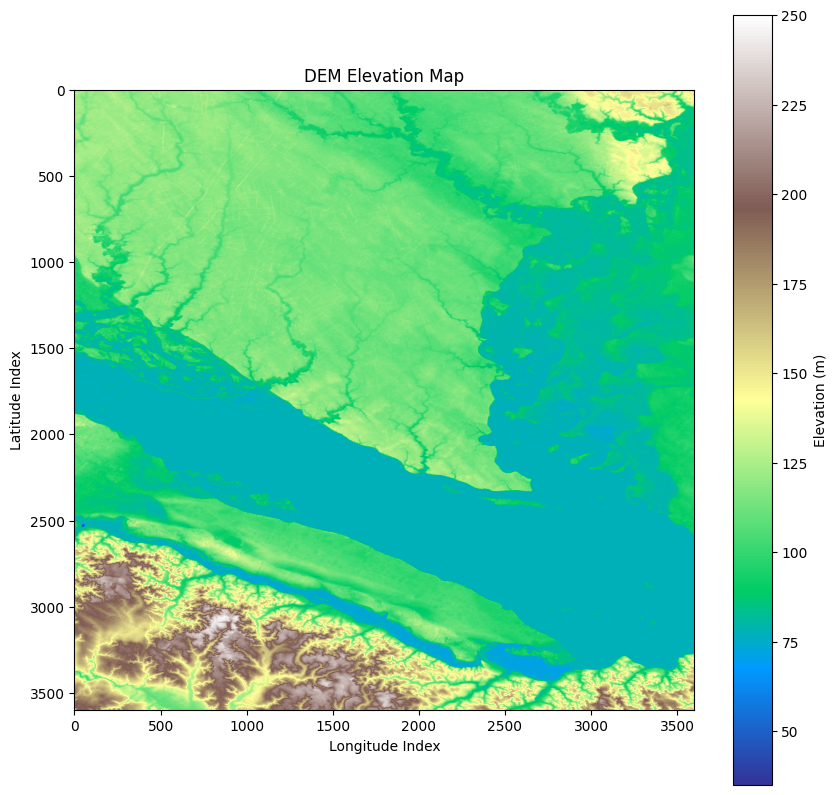

In [6]:
# 지형 고도 정보가 포함되있는 DEM 데이터
plt.figure(figsize=(10, 10))
plt.imshow(elevation, cmap='terrain')
plt.colorbar(label='Elevation (m)')
plt.title('DEM Elevation Map')
plt.xlabel('Longitude Index')
plt.ylabel('Latitude Index')
plt.show()

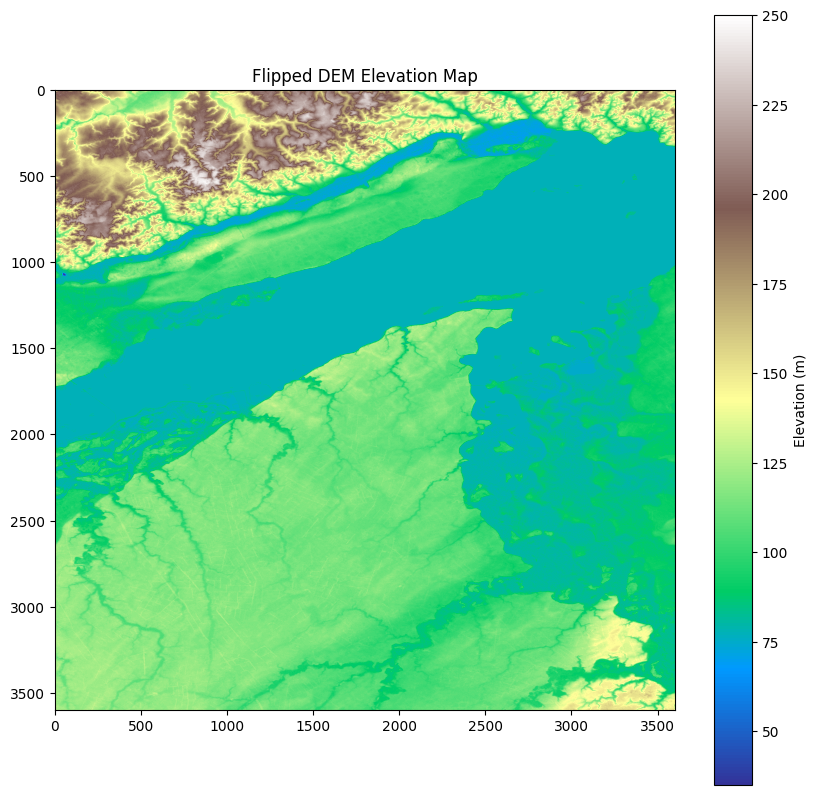

In [7]:
# Assuming flipped_matrix contains the flipped data with tuples in the form of (elevation, longitude, latitude)
# 먼저 시각화를 위해 elevation을 추출
elevation_data_flipped = np.array([[cell[0] for cell in row] for row in flipped_matrix_np])
plt.figure(figsize=(10, 10))
plt.imshow(elevation_data_flipped, cmap='terrain')
plt.colorbar(label='Elevation (m)')
plt.title('Flipped DEM Elevation Map')
plt.show()

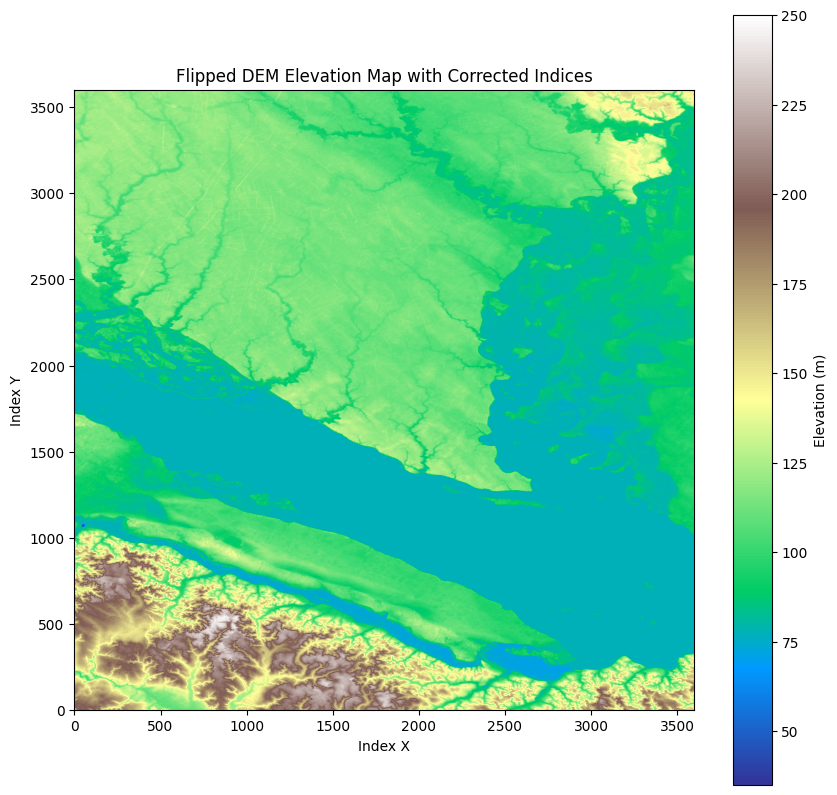

In [8]:
# 인덱스가 바뀐 행렬 데이터를 시각화
plt.figure(figsize=(10, 10))
# Set the extent so that the plot matches your data's geographic extent.
# The format is [left, right, bottom, top].
# Here, we assume your data covers a grid of 3601x3601 starting from bottom-left as [0,0]
plt.imshow(elevation_data_flipped, cmap='terrain', origin='lower', extent=(0.0, 3600.0, 0.0, 3600.00))

plt.colorbar(label='Elevation (m)')
plt.xlabel('Index X')
plt.ylabel('Index Y')
plt.title('Flipped DEM Elevation Map with Corrected Indices')
plt.show()

In [6]:
# 입력 인덱스에 따른 고도, 경도, 위도를 반환하는 함수
def get_data_at_index(matrix, lon_index, lat_index):
    """
    Retrieve elevation, longitude, and latitude data for a specific pixel in the matrix.
    
    Parameters:
    - matrix: The data matrix containing tuples of (elevation, longitude, latitude).
    - lon_index: The longitude index of the pixel.
    - lat_index: The latitude index of the pixel.
    
    Returns:
    - A tuple containing the elevation, longitude, and latitude of the specified pixel, or None if indices are out of bounds.
    """
    # Check if the provided indices are within the bounds of the matrix
    if lat_index >= 0 and lat_index < len(matrix) and lon_index >= 0 and lon_index < len(matrix[0]):
        return matrix[lat_index][lon_index]
    else:
        return None

In [ ]:
# 위의 함수를 사용
lon_index = 0
lat_index = 0
data_at_index = get_data_at_index(matrix_np, lon_index, lat_index)

if data_at_index is not None:
    print(f"Elevation: {data_at_index[0]}, Longitude: {data_at_index[1]}, Latitude: {data_at_index[2]}")
else:
    print("Invalid indices provided.")

In [ ]:
# 위의 함수를 사용
lon_index = 3600
lat_index = 0
data_at_index = get_data_at_index(flipped_matrix_np, 3600-lon_index, 3600-lat_index)

if data_at_index is not None:
    print(f"Elevation: {data_at_index[0]}, Longitude: {data_at_index[1]}, Latitude: {data_at_index[2]}")
else:
    print("Invalid indices provided.")

In [5]:
# 경도와 위도의 최대 인덱스 범위 반환
lat_max_index, lon_max_index = matrix_np.shape[0] - 1, matrix_np.shape[1] - 1

print(f"Maximum Latitude Index: {lat_max_index}")
print(f"Maximum Longitude Index: {lon_max_index}")

Maximum Latitude Index: 3600
Maximum Longitude Index: 3600


In [ ]:
# DEM 데이터를 CSV로 변환 후 저장
# 단순히 각 셀이 고도 값 하나만 가지고 있는 형태로 저장
elevation_data = [[cell[0] for cell in row] for row in matrix_np]

# Assuming longitude and latitude values are evenly spaced and can be derived from the indices
lat_headers = [f"Lat_{i}" for i in range(matrix_np.shape[0])]
lon_headers = [f"Lon_{j}" for j in range(matrix_np.shape[1])]

# Convert elevation data to DataFrame
df = pd.DataFrame(elevation_data, columns=lon_headers)

# Optionally, if you want latitude values as the first column (as index)
df.insert(0, 'Latitude', lat_headers)

# Save to CSV
df.to_csv('elevation_matrix.csv', index=False)

In [ ]:
# 고도, 경도, 위도 데이터를 전부 포함하는 데이터를 저장
elevation_data = [[cell[0] for cell in row] for row in matrix_np]

# Extract longitude and latitude values for headers
# For longitude, take the values from the first row
longitude_values = [cell[1] for cell in matrix_np[0]]  # Assuming all rows have the same longitude values across

# For latitude, take the latitude value of the last cell in each row
latlon_values = [row[-1][2] for row in matrix_np]  # Assuming all columns have the same latitude values down

# Convert elevation data into a DataFrame
df_direct_headers = pd.DataFrame(elevation_data, columns=longitude_values)

# Add latitude values as the first column of the DataFrame
df_direct_headers.insert(0, 'Latitude/Longitude', latlon_values)

# Save the DataFrame to a CSV file
# csv_path_direct = 'C:/Users/leeyj/lab_ws/source'
df_direct_headers.to_csv('NK_DEM.csv', index=False)

In [ ]:
# 인덱스가 바뀌어진 북한 지형 DEM 파일을 저장
csv_file_path = 'C:/Users/leeyj/lab_ws/data/North_Korea_Flipped_DEM.csv'
# Open the file in write mode
with open(csv_file_path, 'w', newline='') as csvfile:
    # Create a CSV writer object
    csvwriter = csv.writer(csvfile)
    
    # Iterate over each cell in the flipped_matrix and write the formatted data to the CSV file
    for row in flipped_matrix_np:
        formatted_row = [f"{cell[1]}, {cell[2]}, {cell[0]}" for cell in row]  # Format: [longitude, latitude, elevation]
        csvwriter.writerow(formatted_row)

print("CSV file has been saved successfully.")

Lambert Conformal Conic Projection, 예전 방식, 부정확함

In [9]:
# LCC Projection에 사용할 중심 경도, 기준 위도 값을 설정
def find_projection_parameters(matrix_np):
    # Extract longitude and latitude values from the matrix
    longitudes = matrix_np[:, :, 1].flatten()  # Assuming longitude is in the second position
    latitudes = matrix_np[:, :, 2].flatten()   # Assuming latitude is in the third position

    # Calculate central longitude (lon_0) as the median of longitudes
    lon_0 = np.median(longitudes)

    # Calculate the first (lat_1) and second (lat_2) standard parallels
    # Use 33rd and 67th percentiles of latitudes to determine these
    lat_1 = np.percentile(latitudes, 33)
    lat_2 = np.percentile(latitudes, 67)

    return lon_0, lat_1, lat_2

In [10]:
# 데이터 확인
lon_0, lat_1, lat_2 = find_projection_parameters(matrix_np)
print(lon_0, lat_1, lat_2)

32.49986111111108 49.33013888885115 49.67013888892669


In [8]:
# # matrix_np에 대한 Lambert Conformal Coninc Projection을 적용하도록 함수 생성
# # Constants for the Lambert Conformal Conic Projection
# # These should be adjusted according to your specific needs or study area
# lat_1 = 38.33013888885115  # First standard parallel
# lat_2 = 38.67013888892669  # Second standard parallel
# lon_0 = 127.49986111111107  # Central meridian
# R = 6378137  # 미터로 표현된 지구의 반지름

# # Convert degrees to radians
# def deg_to_rad(deg):
#     return deg * math.pi / 180

# # Calculation of projection constants
# def calculate_constants(lat_1, lat_2):
#     lat_1_rad = deg_to_rad(lat_1)
#     lat_2_rad = deg_to_rad(lat_2)
    
#     n = math.log(math.cos(lat_1_rad) / math.cos(lat_2_rad)) / \
#         math.log(math.tan(math.pi / 4 + lat_2_rad / 2) / math.tan(math.pi / 4 + lat_1_rad / 2))
#     F = (math.cos(lat_1_rad) * math.pow(math.tan(math.pi / 4 + lat_1_rad / 2), n)) / n
#     rho_0 = R * F * math.pow(math.tan(math.pi / 4 + deg_to_rad(90) / 2), -n)
    
#     return n, F, rho_0

# n, F, rho_0 = calculate_constants(lat_1, lat_2)

# # Function to transform longitude and latitude to Lambert Conformal Conic
# def lambert_conformal_conic_transform(elevation, lon, lat):
#     lat_rad = deg_to_rad(lat)
#     lon_rad = deg_to_rad(lon)
#     rho = R * F * math.pow(math.tan(math.pi / 4 + lat_rad / 2), -n)
#     theta = n * (lon_rad - deg_to_rad(lon_0))
#     x = rho * math.sin(theta)
#     y = rho_0 - rho * math.cos(theta)
#     return elevation, x, y

# # Apply the transformation to the entire DEM matrix
# def apply_projection(matrix_np):
#     transformed_matrix = np.empty(matrix_np.shape, dtype=object)
#     for y in range(matrix_np.shape[0]):
#         for x in range(matrix_np.shape[1]):
#             elev, lon, lat = matrix_np[y, x]
#             transformed_matrix[y, x] = lambert_conformal_conic_transform(elev, lon, lat)
#     return transformed_matrix

In [11]:
# # "인덱스가 바뀐 행렬 데이터"에 Projection 수행하도록 함수 정의
# # Constants for the Lambert Conformal Conic Projection
# # These should be adjusted according to your specific needs or study area
# lat_1 = 38.67013888892669  # First standard parallel
# lat_2 = 38.33013888885115  # Second standard parallel
# lon_0 = 127.49986111111107  # Central meridian
# R = 6378137  # Radius of the Earth in meters (approximation)

# # Convert degrees to radians
# def deg_to_rad(deg):
#     return deg * math.pi / 180

# # Calculation of projection constants
# def calculate_constants(lat_1, lat_2):
#     lat_1_rad = deg_to_rad(lat_1)
#     lat_2_rad = deg_to_rad(lat_2)
    
#     n = math.log(math.cos(lat_1_rad) / math.cos(lat_2_rad)) / \
#         math.log(math.tan(math.pi / 4 + lat_2_rad / 2) / math.tan(math.pi / 4 + lat_1_rad / 2))
#     F = (math.cos(lat_1_rad) * math.pow(math.tan(math.pi / 4 + lat_1_rad / 2), n)) / n
#     rho_0 = R * F * math.pow(math.tan(math.pi / 4 + deg_to_rad(90) / 2), -n)
    
#     return n, F, rho_0

# n, F, rho_0 = calculate_constants(lat_1, lat_2)

# # Function to transform longitude and latitude to Lambert Conformal Conic
# def lambert_conformal_conic_transform(elevation, lon, lat):
#     lat_rad = deg_to_rad(lat)
#     lon_rad = deg_to_rad(lon)
#     rho = R * F * math.pow(math.tan(math.pi / 4 + lat_rad / 2), -n)
#     theta = n * (lon_rad - deg_to_rad(lon_0))
#     x = rho * math.sin(theta)
#     y = rho_0 - rho * math.cos(theta)
#     return elevation, x, y

# # Apply the transformation to the entire DEM matrix
# def apply_projection(flipped_matrix_np):
#     transformed_matrix = np.empty(flipped_matrix_np.shape, dtype=object)
#     for y in range(flipped_matrix_np.shape[0]):
#         for x in range(flipped_matrix_np.shape[1]):
#             elev, lon, lat = flipped_matrix_np[y, x]
#             transformed_matrix[y, x] = lambert_conformal_conic_transform(elev, lon, lat)
#     return transformed_matrix

In [9]:
# # 실제 적용
# LCC_matrix = apply_projection(matrix_np)

In [10]:
# LCC_matrix

array([[[869.0, -43256.90877201113, -7962552.493276264],
        [872.0, -43232.877392237555, -7962552.623791503],
        [873.0, -43208.84601207018, -7962552.754234213],
        ...,
        [0.0, 43208.84601207018, -7962552.754234213],
        [0.0, 43232.87739223975, -7962552.623791503],
        [0.0, 43256.90877201333, -7962552.493276264]],

       [[870.0, -43257.07676073236, -7962583.41594386],
        [867.0, -43233.04528763262, -7962583.546459606],
        [863.0, -43209.0138141391, -7962583.676902823],
        ...,
        [0.0, 43209.0138141391, -7962583.676902823],
        [0.0, 43233.04528763483, -7962583.546459606],
        [0.0, 43257.07676073456, -7962583.41594386]],

       [[867.0, -43257.24474944645, -7962614.338610143],
        [863.0, -43233.213183020576, -7962614.469126396],
        [858.0, -43209.1816162009, -7962614.599570121],
        ...,
        [0.0, 43209.1816162009, -7962614.599570121],
        [0.0, 43233.21318302277, -7962614.469126396],
        [0.0, 43

In [12]:
# # Flip 된 데이터의 경우 LCC를 적용
# flipped_LCC_matrix = apply_projection(flipped_matrix_np)

In [13]:
# flipped_LCC_matrix

array([[[94.0, -43861.6527822491, -8073871.264400322],
        [88.0, -43837.285436883234, -8073871.396740201],
        [79.0, -43812.918091118074, -8073871.529006539],
        ...,
        [325.0, 43812.918091118074, -8073871.529006539],
        [326.0, 43837.28543688547, -8073871.396740201],
        [338.0, 43861.65278225133, -8073871.264400322]],

       [[97.0, -43861.484793554024, -8073840.3417375395],
        [92.0, -43837.11754151429, -8073840.474076912],
        [86.0, -43812.75028907527, -8073840.606342743],
        ...,
        [302.0, 43812.75028907527, -8073840.606342743],
        [306.0, 43837.11754151653, -8073840.474076912],
        [328.0, 43861.48479355626, -8073840.3417375395]],

       [[93.0, -43861.31680486604, -8073809.419076061],
        [91.0, -43836.94964615244, -8073809.5514149275],
        [87.0, -43812.58248703955, -8073809.683680251],
        ...,
        [280.0, 43812.58248703955, -8073809.683680251],
        [290.0, 43836.94964615467, -8073809.5514149275]

In [27]:
# # LCC_matrix와 flipped_LCC_matrix의 데이터 일치도 검증
# # 일치함을 확인
# print(LCC_matrix[0, 0], flipped_LCC_matrix[3600, 0])
# print(LCC_matrix[0,-1], flipped_LCC_matrix[-1,-1])
# print(LCC_matrix[3600, 0], flipped_LCC_matrix[0,0])
# print(LCC_matrix[3600, -1], flipped_LCC_matrix[0, -1])

[869.0 -43256.90877201113 -7962552.493276264] [869.0 -43256.90877201113 -7962552.493276264]
[0.0 43256.90877201333 -7962552.493276264] [0.0 43256.90877201333 -7962552.493276264]
[94.0 -43861.6527822491 -8073871.264400435] [94.0 -43861.6527822491 -8073871.264400435]
[338.0 43861.65278225133 -8073871.264400435] [338.0 43861.65278225133 -8073871.264400435]


In [18]:
# # LCC Projection을 적용한 데이터를 3차원상으로 Plot
# def plot_lcc_dem_3d(LCC_matrix):
#     # Assuming LCC_matrix is structured with each element as (elevation, x, y)
#     # Extracting elevation, x, and y values
#     elevations = LCC_matrix[:, :, 0].astype(float)  # Convert to float if not already
#     xs = LCC_matrix[:, :, 1].astype(float)
#     ys = LCC_matrix[:, :, 2].astype(float)

#     # Create a 3D plot
#     fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
#     # Create a surface plot using x, y, and elevation
#     surf = ax.plot_surface(xs, ys, elevations, cmap='viridis', edgecolor='none')

#     # Add a color bar which maps values to colors.
#     cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
#     cbar.set_label('Elevation (meters)')

#     ax.set_xlabel('X Coordinate (meters)')
#     ax.set_ylabel('Y Coordinate (meters)')
#     ax.set_zlabel('Elevation (meters)')

#     plt.title('Lambert Conformal Conic Projection of DEM')
#     plt.show()

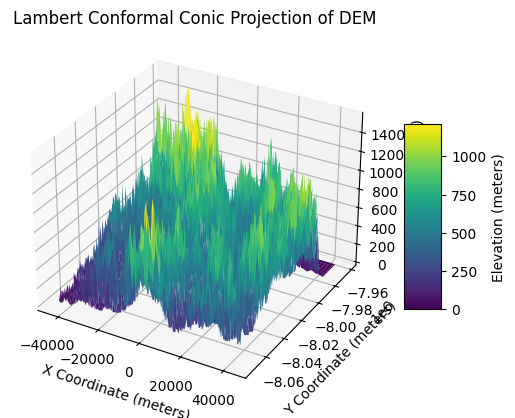

In [19]:
# plot_lcc_dem_3d(LCC_matrix)

In [11]:
# # 이전 행렬 데이터 matrix_np 및 flipped_matrix_np의 plotting 방식과 마찬가지로 음영을 통해 2차원 지도를 plot
# def plot_lcc_dem_2d(LCC_matrix):
#     # Assuming LCC_matrix is structured with each element as (elevation, x, y)
#     # Extracting elevation, x, and y values
#     elevations = LCC_matrix[:, :, 0].astype(float)  # Convert to float if not already
#     xs = LCC_matrix[:, :, 1].astype(float)
#     ys = LCC_matrix[:, :, 2].astype(float)

#     # Create a 2D plot
#     fig, ax = plt.subplots()
#     # Create a contour plot using x, y, and elevation
#     contour = ax.contourf(xs, ys, elevations, cmap='terrain', levels=100)

#     # Add a color bar which maps values to colors.
#     cbar = fig.colorbar(contour)
#     cbar.set_label('Elevation (meters)')

#     ax.set_xlabel('X Coordinate (meters)')
#     ax.set_ylabel('Y Coordinate (meters)')
#     plt.title('Lambert Conformal Conic Projection of DEM - 2D View')
#     plt.show()

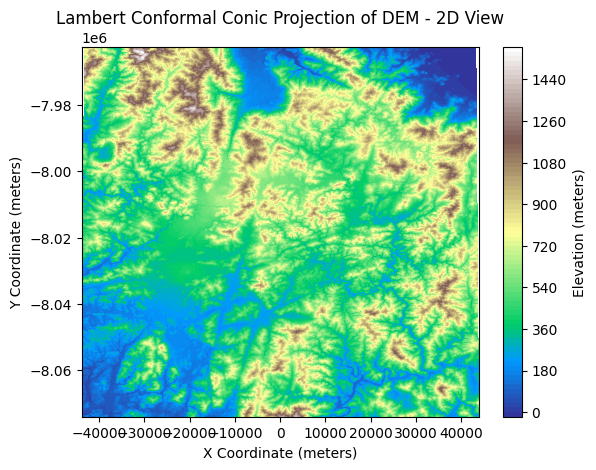

In [12]:
# plot_lcc_dem_2d(LCC_matrix)

In [13]:
# # LCC Projectioin이 적용된 LCC_matrix를 단순 flipud 함수를 통해 인덱스 반전
# flipped_LCC_matrix = np.flipud(LCC_matrix)

In [14]:
# def plot_flipped_lcc_dem_2d(flipped_LCC_matrix):
#     # Assuming flipped_LCC_matrix is structured with each element as (elevation, x, y)
#     # Extracting elevation, x, and y values
#     elevations = flipped_LCC_matrix[:, :, 0].astype(float)
#     xs = flipped_LCC_matrix[:, :, 1].astype(float)
#     ys = flipped_LCC_matrix[:, :, 2].astype(float)
    
#     # Flipping ys to reflect the vertical flipping of the matrix in the plot
#     ys = np.max(ys) - ys + np.min(ys)

#     # Create a 2D plot
#     fig, ax = plt.subplots()
#     # Create a contour plot using x, y, and elevation
#     contour = ax.contourf(xs, ys, elevations, cmap='terrain', levels=100)

#     # Add a color bar which maps values to colors.
#     cbar = fig.colorbar(contour)
#     cbar.set_label('Elevation (meters)')

#     ax.set_xlabel('X Coordinate (meters)')
#     ax.set_ylabel('Y Coordinate (meters)')
#     plt.title('Flipped Lambert Conformal Conic Projection of DEM - 2D View')
#     plt.show()

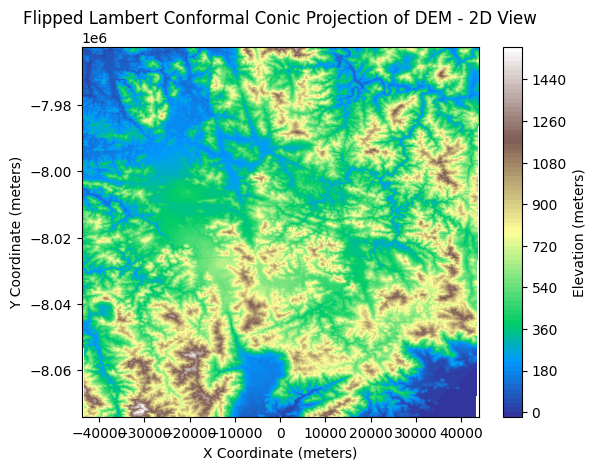

In [29]:
# # Assuming flipped_LCC_matrix is your loaded DEM data after flipping
# plot_flipped_lcc_dem_2d(flipped_LCC_matrix)

In [22]:
# # 인덱스가 바뀌어진 LCC 적용 북한 지형 DEM 파일을 저장
# csv_file_path = 'C:/Users/leeyj/Downloads/VTD/North_Korea_DEM_LCC.csv'
# # Open the file in write mode
# with open(csv_file_path, 'w', newline='') as csvfile:
#     # Create a CSV writer object
#     csvwriter = csv.writer(csvfile)
    
#     # Iterate over each cell in the flipped_matrix and write the formatted data to the CSV file
#     for row in flipped_LCC_matrix:
#         formatted_row = [f"{cell[1]}, {cell[2]}, {cell[0]}" for cell in row]  # Format: [longitude, latitude, elevation]
#         csvwriter.writerow(formatted_row)

# print("CSV file has been saved successfully.")

CSV file has been saved successfully.


pyproj를 이용한 LCC 적용

In [11]:
# Extract LCC parameters (set according to your region of interest)
# lat_1 = 38.33013888885115  # First standard parallel
# lat_2 = 38.67013888892669  # Second standard parallel
# lon_0 = 127.49986111111107  # Central meridian
lat_1 = 49.33013888885115  # First standard parallel
lat_2 = 49.67013888892669  # Second standard parallel
lon_0 = 32.49986111111108  # Central meridian
lat_0 = (lat_1 + lat_2) / 2  # Latitude of origin
proj_lcc = Proj(proj="lcc", lat_1=lat_1, lat_2=lat_2, lat_0=lat_0, lon_0=lon_0, ellps="WGS84")

# Initialize lists to store transformed coordinates
transformed_data = []

# Calculate longitude, latitude for each pixel and apply LCC projection
for y in range(elevation.shape[0]):
    for x in range(elevation.shape[1]):
        longitude = geotransform[0] + x * geotransform[1] + y * geotransform[2]
        latitude = geotransform[3] + x * geotransform[4] + y * geotransform[5]
        elev = elevation[y, x]

        # Transform coordinates using pyproj
        x_proj, y_proj = proj_lcc(longitude, latitude)
        transformed_data.append((elev, x_proj, y_proj))

# Convert transformed data to a NumPy array
transformed_array = np.array(transformed_data).reshape(elevation.shape[0], elevation.shape[1], 3)

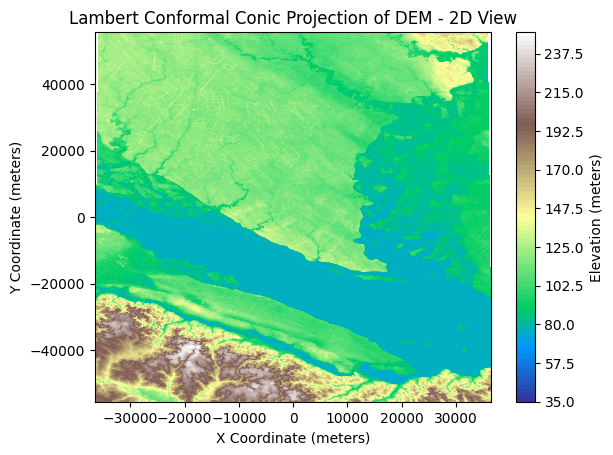

In [12]:
# 매트랩에서 사용할 수 있게끔 LCC적용 및 구조체 생성

def plot_lcc_dem_2d(transformed_array):
    # 배열로부터 고도, x, y데이터 추출
    elevations = transformed_array[:, :, 0].astype(float)
    xs = transformed_array[:, :, 1].astype(float)
    ys = transformed_array[:, :, 2].astype(float)

    fig, ax = plt.subplots()
    contour = ax.contourf(xs, ys, elevations, cmap='terrain', levels=100)
    cbar = fig.colorbar(contour)
    cbar.set_label('Elevation (meters)')
    ax.set_xlabel('X Coordinate (meters)')
    ax.set_ylabel('Y Coordinate (meters)')
    plt.title('Lambert Conformal Conic Projection of DEM - 2D View')
    plt.show()

plot_lcc_dem_2d(transformed_array)


In [13]:
transformed_array[3600,3600]

array([   161.        ,  36586.75083491, -55486.35663824])

In [14]:
# 인덱스 반전
flipped_transformed_array = np.flipud(transformed_array)

In [ ]:
# print(transformed_array[0, 0], flipped_transformed_array[3600, 0])
# print(transformed_array[0,-1], flipped_transformed_array[-1,-1])
# print(transformed_array[3600, 0], flipped_transformed_array[0,0])
# print(transformed_array[3600, -1], flipped_transformed_array[0, -1])

[   869.         -43314.36031173  55623.47173993] [   869.         -43314.36031173  55623.47173993]
[    0.         43314.36031174 55623.47173993] [    0.         43314.36031174 55623.47173993]
[    94.         -43917.40110249 -55381.77512386] [    94.         -43917.40110249 -55381.77512386]
[   338.          43917.40110251 -55381.77512386] [   338.          43917.40110251 -55381.77512386]


In [28]:
# pyproj를 통해 생성된 LCC 투영 결과 DEM 데이터를 csv 포맷으로 저장

file_path = 'C:/Users/leeyj/lab_ws/data/VTD/지형 데이터/target_lotation_DTED_LCC.csv'

with open(file_path, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    for row in transformed_array:
        formatted_row = [f"{cell[1]}, {cell[2]}, {cell[0]}" for cell in row]  # longitude, latitude, elevation 형식
        csvwriter.writerow(formatted_row)

In [15]:
# 축이 바뀐 결과를 csv로 저장

file_path = 'C:/Users/leeyj/lab_ws/data/VTD/지형 데이터/flipped_target_lotation_DTED_LCC.csv'

with open(file_path, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    for row in flipped_transformed_array:
        formatted_row = [f"{cell[1]}, {cell[2]}, {cell[0]}" for cell in row]  # longitude, latitude, elevation 형식
        csvwriter.writerow(formatted_row)

In [9]:
# 각 셀에 하나의 값만 있도록 하는 csv파일을 생성

file_path = 'C:/Users/leeyj/lab_ws/data/VTD/지형 데이터/latitude.csv'

with open(file_path, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    for row in flipped_transformed_array:
        formatted_row = [f"{cell[2]}" for cell in row]
        csvwriter.writerow(formatted_row)

In [8]:

lat_1 = 49.33013888885115  # First standard parallel
lat_2 = 49.67013888892669  # Second standard parallel
lon_0 = 32.49986111111108  # Central meridian
lat_0 = (lat_1 + lat_2) / 2  # Latitude of origin
proj_lcc = Proj(proj="lcc", lat_1=lat_1, lat_2=lat_2, lat_0=lat_0, lon_0=lon_0, ellps="WGS84")

x_list = []
y_list = []
alt_list = []

# Loop through DEM data and apply LCC projection
for y in range(elevation.shape[0]):
    for x in range(elevation.shape[1]):
        # Calculate geographic coordinates
        longitude = geotransform[0] + x * geotransform[1] + y * geotransform[2]
        latitude = geotransform[3] + x * geotransform[4] + y * geotransform[5]
        elev = elevation[y, x]

        # Skip invalid elevation values
        if np.isnan(elev):
            continue

        # Apply LCC projection
        x_proj, y_proj = proj_lcc(longitude, latitude)

        # Append results to lists
        x_list.append(x_proj)
        y_list.append(y_proj)
        alt_list.append(elev)

# Convert lists to numpy arrays
x_array = np.array(x_list)
y_array = np.array(y_list)
alt_array = np.array(alt_list)

# Reshape the arrays to match elevation shape
x_array = x_array.reshape(elevation.shape)
y_array = y_array.reshape(elevation.shape)
alt_array = alt_array.reshape(elevation.shape)

# Shift coordinates so the lower-left corner becomes (0, 0)
x_min, y_min = x_array.min(), y_array.min()
x_array -= x_min
y_array -= y_min

# Create MATLAB structure
mat_struct = {
    "X": x_array,
    "Y": y_array,
    "alt": alt_array
}

# Save to .mat file
output_file = "C:/Users/leeyj/lab_ws/data/VTD/Radar/output_map.mat"
savemat(output_file, {"MAP": mat_struct})

print(f"MAT file saved successfully to {output_file}")

# # Convert lists to numpy arrays
# x_array = np.array(x_list)
# y_array = np.array(y_list)
# alt_array = np.array(alt_list)

# # Create MATLAB structure
# mat_struct = {
#     "X": x_array.reshape(elevation.shape),
#     "Y": y_array.reshape(elevation.shape),
#     "alt": alt_array.reshape(elevation.shape)
# }

# # Save to .mat file
# output_file = "C:/Users/ThinkYun/lab_ws/data/VTD/Radar/output_map_struct.mat"  # Replace with your desired output path
# savemat(output_file, {"MAP": mat_struct})

# print(f"MAT file saved successfully to {output_file}")

MAT file saved successfully to C:/Users/leeyj/lab_ws/data/VTD/Radar/output_map.mat


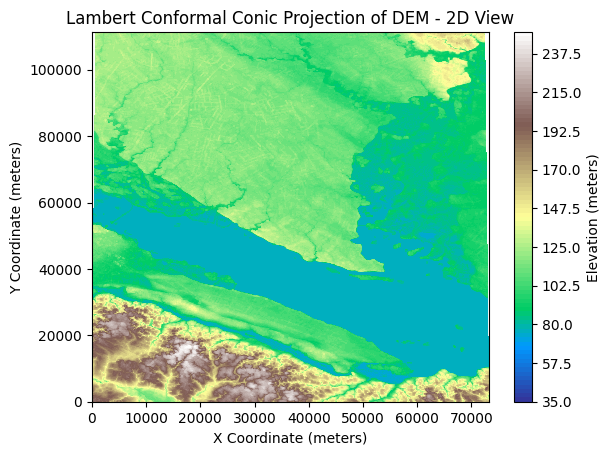

In [6]:
# Combine arrays into a single transformed array
transformed_array = np.stack((alt_array, x_array, y_array), axis=-1)

# Define the plotting function
def plot_lcc_dem_2d(transformed_array):
    # Extract elevation, x, y data
    elevations = transformed_array[:, :, 0].astype(float)
    xs = transformed_array[:, :, 1].astype(float)
    ys = transformed_array[:, :, 2].astype(float)

    fig, ax = plt.subplots()
    contour = ax.contourf(xs, ys, elevations, cmap='terrain', levels=100)
    cbar = fig.colorbar(contour)
    cbar.set_label('Elevation (meters)')
    ax.set_xlabel('X Coordinate (meters)')
    ax.set_ylabel('Y Coordinate (meters)')
    plt.title('Lambert Conformal Conic Projection of DEM - 2D View')
    plt.show()

# Plot the transformed DEM
plot_lcc_dem_2d(transformed_array)